# Data Structures


In [1]:
import uxarray as ux
import xarray as xr

C:\Users\chmie\anaconda3\envs\uxarray_build\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 12.0.1 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


UXarray provides three data structures for interacting with unstructured grids and the data variables that reside on them:

1. **ux.Grid**: Stores the grid representation (i.e. coordinates, connectivity information, etc.)
2. **ux.UxDataset**: One or more data variable that resided on a grid.
3. **ux.UxDataArray**: A single data variable that resides on a grid 


## Grid and Data Files

When working with unstructured grid datasets, the grid definition is typically stored separately from any data variables. 

For example, the dataset we're using in this example is made up of two files: 1 grid definition and 1 data file.

```
quad-hexagon
│   grid.nc
│   data.nc
```

In [23]:
grid_path = "../../test/meshfiles/ugrid/quad-hexagon/grid.nc"
data_path = "../../test/meshfiles/ugrid/quad-hexagon/data.nc"

Additionally, there may be multiple data files that are mapped to the same unstructured grid (think climate model history files). Using our sample dataset, this may look something like this:

```
quad-hexagon
│   grid.nc
│   data1.nc
|   data2.nc
|   data3.nc
|   data4.nc
```

We can store these paths as a list (in this case we simply repeat the original data file to imitate having 4 separate data files)

In [24]:
multiple_data_paths = [data_path for i in range(4)]

## Grid

UXarray's `Grid` class is used for representing unstructured grids in terms of their coordinates and connectivity information.

### Creating a Grid

The recommended way to construct a `Grid` is by using the `ux.open_grid()` method, which takes in a grid file path, detects the input grid format, and parses and encodes the provided coordinates and connectivity into the UGRID conventions. Details on supported grid formats and what variables are parsed can be found in other parts of this user guide.

In [4]:
uxgrid = ux.open_grid(grid_path)
uxgrid

<uxarray.Grid>
Original Grid Type: UGRID
Grid Dimensions:
  * n_node: 16
  * n_face: 4
  * n_edge: 19
  * two: 2
  * n_max_face_nodes: 6
  * n_nodes_per_face: (4,)
Grid Coordinates (Spherical):
  * node_lon: (16,)
  * node_lat: (16,)
  * edge_lon: (19,)
  * edge_lat: (19,)
  * face_lon: (4,)
  * face_lat: (4,)
Grid Coordinates (Cartesian):
Grid Connectivity Variables:
  * face_node_connectivity: (4, 6)
  * edge_node_connectivity: (19, 2)

### Grid Attributes

Each `Grid` contains multiple dimensions, coordinates, connectivity, and descriptor variables that represent an unstructured grid. All currently avaliable variables can be viewed by printing a `Grid`


In [5]:
uxgrid

<uxarray.Grid>
Original Grid Type: UGRID
Grid Dimensions:
  * n_node: 16
  * n_face: 4
  * n_edge: 19
  * two: 2
  * n_max_face_nodes: 6
  * n_nodes_per_face: (4,)
Grid Coordinates (Spherical):
  * node_lon: (16,)
  * node_lat: (16,)
  * edge_lon: (19,)
  * edge_lat: (19,)
  * face_lon: (4,)
  * face_lat: (4,)
Grid Coordinates (Cartesian):
Grid Connectivity Variables:
  * face_node_connectivity: (4, 6)
  * edge_node_connectivity: (19, 2)

These variables can be accessed as an attribute of the `Grid` class. 

In [6]:
uxgrid.n_node

16

In [7]:
uxgrid.face_node_connectivity

<xarray.DataArray 'face_node_connectivity' (n_face: 4, n_max_face_nodes: 6)>
array([[ 0,  1,  2,  3,  4,  5],
       [15,  7,  6, 12,  0,  5],
       [ 0, 12,  8,  9, 13,  1],
       [ 4, 14, 11, 10, 15,  5]], dtype=int64)
Dimensions without coordinates: n_face, n_max_face_nodes
Attributes:
    _FillValue:  -9223372036854775808

## UxDataset

Up to this point, we've exclusively looked at the unstructured grid without any data variables mapped to it. When working with one or more data variables, they are linked to a grid through a `UxDataset` instance.

When pairing data variables with an unstructured grid files, they can be opened together using the `ux.open_dataset()` method, which returns a ``UxDataset``


### Opening a Single Data File

We can load a pair of grid and data files using the `ux.open_dataset()` method.



In [8]:
uxds = ux.open_dataset(grid_path, data_path)
uxds

<xarray.UxDataset>
Dimensions:  (n_face: 4)
Dimensions without coordinates: n_face
Data variables:
    t2m      (n_face) float32 297.6 297.6 297.7 297.3

### Opening Multiple Data Files

When working with multiple data paths, we can open them using the `ux.open_mfdataset()` method. 

In [9]:
uxds_multi = ux.open_mfdataset(grid_path, multiple_data_paths, combine ='nested', concat_dim='time')
uxds_multi

<xarray.UxDataset>
Dimensions:  (time: 10, n_face: 4)
Dimensions without coordinates: time, n_face
Data variables:
    t2m      (time, n_face) float32 dask.array<chunksize=(1, 4), meta=np.ndarray>

## Grid Accessor

Each `UxDataset` (and in the next section `UxDataArray`) is linked to a `Grid` instance, which contain the unstructured grid information

In [10]:
uxds.uxgrid

<uxarray.Grid>
Original Grid Type: UGRID
Grid Dimensions:
  * n_node: 16
  * n_face: 4
  * n_edge: 19
  * two: 2
  * n_max_face_nodes: 6
  * n_nodes_per_face: (4,)
Grid Coordinates (Spherical):
  * node_lon: (16,)
  * node_lat: (16,)
  * edge_lon: (19,)
  * edge_lat: (19,)
  * face_lon: (4,)
  * face_lat: (4,)
Grid Coordinates (Cartesian):
Grid Connectivity Variables:
  * face_node_connectivity: (4, 6)
  * edge_node_connectivity: (19, 2)

## UxDataArray

While a `UxDataset` represents one or more data variables linked to some unstructured grid, a `UxDataArray` represent a single data variable. Alternatively, one can think of a `UxDataset` as a collection of one or more `UxDataArray` instances.

In our sample dataset, we have a variable called `t2m`, which can be used to index our `UxDataset`


In [11]:
uxds['t2m']

<xarray.UxDataArray 't2m' (n_face: 4)>
array([297.58316, 297.64578, 297.71643, 297.25037], dtype=float32)
Dimensions without coordinates: n_face
Attributes:
    units:      K
    long_name:  2-meter temperature

As mentioned before, each `UxDataArray` is linked to a `Grid` instance.

In [12]:
uxds['t2m'].uxgrid

<uxarray.Grid>
Original Grid Type: UGRID
Grid Dimensions:
  * n_node: 16
  * n_face: 4
  * n_edge: 19
  * two: 2
  * n_max_face_nodes: 6
  * n_nodes_per_face: (4,)
Grid Coordinates (Spherical):
  * node_lon: (16,)
  * node_lat: (16,)
  * edge_lon: (19,)
  * edge_lat: (19,)
  * face_lon: (4,)
  * face_lat: (4,)
Grid Coordinates (Cartesian):
Grid Connectivity Variables:
  * face_node_connectivity: (4, 6)
  * edge_node_connectivity: (19, 2)

This Grid is identical to the one linked to the `UxDataset`. There is a single `Grid` that is shared by all data variables.

Just like with Xarray, we can perform various operations on our data variable

In [13]:
uxds['t2m'].uxgrid == uxds.uxgrid

True

In [14]:
uxds['t2m'].min()

<xarray.UxDataArray 't2m' ()>
array(297.25037, dtype=float32)

In [15]:
uxds['t2m'].mean()

<xarray.UxDataArray 't2m' ()>
array(297.54895, dtype=float32)

UXarray also provides custom data analysis operators which are explored in further sections of this user guide

In [16]:
uxds['t2m'].gradient()

<xarray.UxDataArray 't2m_grad' (n_edge: 19)>
array([28.00277097, 20.66935101, 29.23128307,  0.        ,  0.        ,
        0.        ,  0.        , 60.59822029,  0.        , 86.32623052,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])
Dimensions without coordinates: n_edge

## Inheritance from Xarray

For those that are familiar with Xarray, the naming of the methods and data structures looks familiar. UXarray aims to provide a familiar experience to Xarray by inheriting the `xr.Dataset` and `xr.DataArray` objects and linking them to an instance of a `Grid` class to provide grid-aware implementations.

We can observe this inheritance by checking for subclassing.

In [17]:
issubclass(ux.UxDataset, xr.Dataset)

True

In [18]:
issubclass(ux.UxDataArray, xr.DataArray)

True

## Overloaded Methods

With subclassing, all methods are inherited by default. This means that while most will execute, their output may not be as expected. We have re-implemented and added many new methods to provide grid-aware implementations of their Xarray counterparts. 

These are discussed in detail in the next sections, but one notable example are all the plotting methods are all custom to support unstructured grid visualuzation.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Polygons   [x,y]   (t2m)
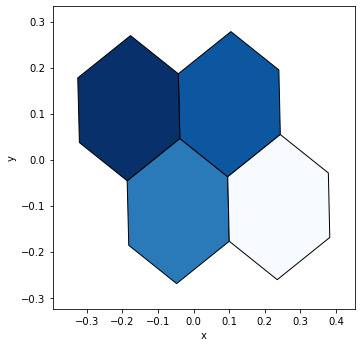

In [22]:
uxds['t2m'].plot(fig_size=150, colorbar=False, backend='matplotlib')